# Gradient Descent for Linear Systems

## Gradient Descent for a Linear System

Here we will be minimizing the mean square error of $Ax=b$.  That is, we seek to minimize
$$ MSE = \frac{1}{n} \sum_{i=1}^n \left ( b_i - A_i x \right )^2 $$
It turns out the gradient of $MSE$ can be written
$$ \nabla MSE = \frac{2}{n}A'(b-Ax)$$
This means that each iteration of our gradient descent can be written as
$$x^+ = x^c + \alpha A'(b-Ax^c)$$

In [110]:
function grlinearupdate(A, b, xc, alpha)
    x = xc + alpha*A'*(b-A*xc)
    return(x)
end

grlinearupdate (generic function with 1 method)

In [111]:
function grl_fixed(A, b, x0; alpha=0.01, eps=10e-8, maxiter=25)
    delta = 1
    xc = copy(x0)
    check = norm(A*xc-b)^2
    iter = 1
    xlog = Matrix{Float64}(undef, maxiter, 2)
    xlog[iter,1] = xc[1]
    xlog[iter,2] = xc[2]
    while delta>eps && iter<maxiter
        iter += 1
        xp = grlinearupdate(A, b,xc, alpha)
#println(xp)
        xlog[iter,1] = xp[1]
        xlog[iter,2] = xp[2]
        xc = copy(xp)
        checkp = norm(A*xp-b)^2
        delta = abs(check - checkp)
        check = copy(checkp)
    end
    xlog = xlog[1:iter,:]
    return xc, check, iter, xlog
end

grl_fixed (generic function with 1 method)

In [112]:
x0 = [0,0]   # initial guess
alpha = 0.01;    # fixed step size

In [113]:
include("../jl/gen_Axb.jl")
using LinearAlgebra

A,x,b = gen_Axb(100);
A\b

2-element Array{Float64,1}:
 0.8728245232982108
 1.9689572381195182

In [114]:
norm(A*x-b)^2

91.0494494966991

In [115]:
xp = grlinearupdate(A, b, x0, alpha)

2-element Array{Float64,1}:
 1.819914128154543
 1.03406577887482 

In [116]:
solution, sse, iters, sols = grl_fixed(A,b,x0; alpha=0.01, maxiter=200);
println(iters)
println(solution)

126
[0.872971, 1.96867]


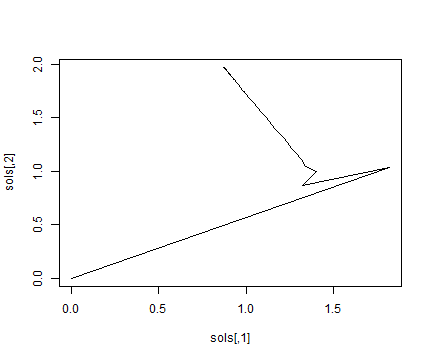

In [117]:
using RCall
@rput sols
reval("plot(sols, type='l')");

## Pick a better alpha

Is there a good way to pick the step size, $\alpha$?

We will consider 4 strategies:  two are based on the residuals of the next estimate, two are based on deviations from the exact solution.

Let $r^+$ be the residuals from the next estimate, in other words
$$r^+ = Ax^+-b$$

### Strategy 1:  $\min_{\alpha} \lVert r^+ \rVert_2^2$

***Lemma***: the $\alpha$ that minimizes the next residuals in each step of our gradient update is
$$\alpha=\frac{\lVert A'r^c \rVert_2^2}{\lVert AA'r^c \rVert_2^2}$$

*Proof*:  $\min_\alpha \lVert r^+ \rVert_2^2 $
$$=\min_\alpha \lVert Ax^+ - b \rVert_2^2$$
$$=\min_\alpha \lVert A(x^c+\alpha A'(b-Ax^c)) - b \rVert_2^2$$
$$=\min_\alpha \lVert Ax^c+\alpha AA'(b-Ax^c) - b \rVert_2^2$$
$$=\min_\alpha \lVert (Ax^c-b)+\alpha AA'(b-Ax^c) \rVert_2^2$$
$$=\min_\alpha \lVert r^c+\alpha AA'(-r^c) \rVert_2^2$$
Somehow this ends up
$$=\min_\alpha \left (\lVert r^c \rVert_2^2 -2\alpha \lVert A'r^c \rVert_2^2 
+ \alpha^2 \lVert AA'r^c \rVert_2^2\right )$$
Taking the derivative with respect to $\alpha$ and setting it equal to 0
$$0= -2 \lVert A'r^c \rVert_2^2 + 2 \alpha \lVert AA'r^c \rVert_2^2$$
$$\alpha\lVert A'r^c \rVert_2^2 = \lVert AA'r^c \rVert_2^2$$
$$\alpha = \frac{\lVert A'r^c \rVert_2^2}{\lVert AA'r^c \rVert_2^2}$$

Alpha adapts at each step.  The initial alpha is

In [118]:
alpha = norm(A'*(A*x0-b))^2/norm(A*A'*(A*x0-b))^2

0.00803024312084721

While alpha at the solution would be

In [119]:
alpha = norm(A'*(A*x-b))^2/norm(A*A'*(A*x-b))^2

0.008018161973575352

Using this final calculation to set a fixed alpha somewhat reduces the number of steps we take.

In [120]:
solution, sse, iters, sols = grl_fixed(A,b,x0; alpha=alpha, maxiter=200);
println(iters)
println(solution)

156
[0.872987, 1.96864]


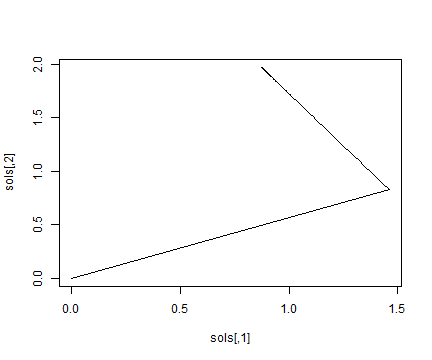

In [121]:
@rput sols
reval("plot(sols, type='l')");

In [122]:
function grl_1(A, b, x0; eps=10e-8, maxiter=25)
    delta = 1
    xc = copy(x0)
    check = norm(A*xc-b)^2
    iter = 1
    xlog = Matrix{Float64}(undef, maxiter, 2)
    xlog[iter,1] = xc[1]
    xlog[iter,2] = xc[2]
    while delta>eps && iter<maxiter
        iter += 1
        rc = A*xc-b
        alpha = norm(A'*rc)^2/norm(A*A'*rc)^2
        xp = grlinearupdate(A, b, xc, alpha)
        xlog[iter,1] = xp[1]
        xlog[iter,2] = xp[2]
        xc = copy(xp)
        checkp = norm(A*xp-b)^2
        delta = abs(check - checkp)
        check = copy(checkp)
    end
    xlog = xlog[1:iter,:]
    return xc, check, iter, xlog
end

grl_1 (generic function with 1 method)

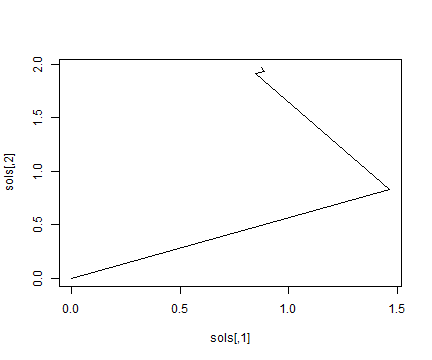

9
[0.872824, 1.96896]


In [123]:
x0 = [0.,0]
solution, sse, iters, sols = grl_1(A,b,x0; maxiter=100);
println(iters)
println(solution)
@rput sols
reval("plot(sols, type='l')");

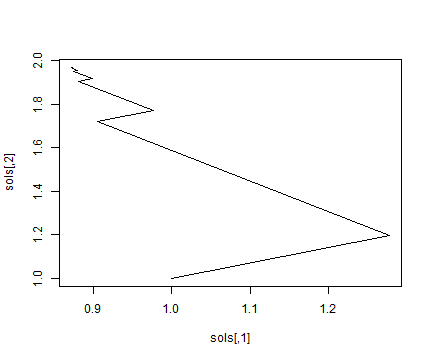

16
[0.872855, 1.9689]


In [124]:
x0 = [1,1]
solution, sse, iters, sols = grl_1(A,b,x0; maxiter=100);
println(iters)
println(solution)
@rput sols
reval("plot(sols, type='l')");

### Strategy 2: $\min_\alpha \lVert x^+-x^* \rVert_2^2$

This is not of practical use, because we won't know the true solution, $x^*$.

The $\alpha$ that minimizes this is
$$\alpha=\frac{\lVert x^c-x^* \rVert_2^2}{\lVert A'r^c \rVert_2^2}$$

In [125]:
function grl_2(A, b, x0, x; eps=10e-8, maxiter=25)
    delta = 1
    xc = copy(x0)
    check = norm(xc-x)^2
    iter = 1
    xlog = Matrix{Float64}(undef, maxiter, 2)
    xlog[iter,1] = xc[1]
    xlog[iter,2] = xc[2]
    while delta>eps && iter<maxiter
        iter += 1
        rc = A*xc-b
#        alpha = norm(A*(xc-x))^2/norm(A*A'*rc)^2
        alpha = norm(xc-x)^2/norm(A'*rc)^2
#        println(alpha)
        xp = grlinearupdate(A, b, xc, alpha)
        xlog[iter,1] = xp[1]
        xlog[iter,2] = xp[2]
        xc = copy(xp)
        checkp = norm(xc-x)^2
        delta = abs(check - checkp)
        check = copy(checkp)      
    end
    xlog = xlog[1:iter,:]
    return xc, check, iter, xlog
end

grl_2 (generic function with 1 method)

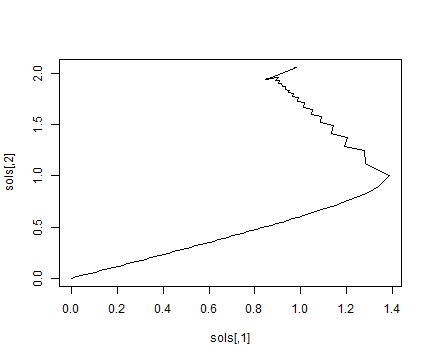

153
[0.970325, 2.05577]


In [127]:
x0 = [0,0]
solution, sse, iters, sols = grl_2(A,b,x0,x; maxiter=500);
println(iters)
println(solution)
@rput sols
reval("plot(sols, type='l')");

### Strategy 3:  $\min_\alpha (\lVert I - \alpha AA' \rVert_2^2 \lVert r^c \rVert_2^2)$

This is a variant of Strategy 1, by the Triangle Inequality (for norms).

Here 
$$\alpha = \frac{\lVert A' \rVert^2_2}{\lVert AA' \rVert^2_2}$$
This $\alpha$ does not update, so we can supply it to our fixed-step algorithm.

In [128]:
alpha = norm(A)^2/norm(A*A')^2

0.008409654677839749

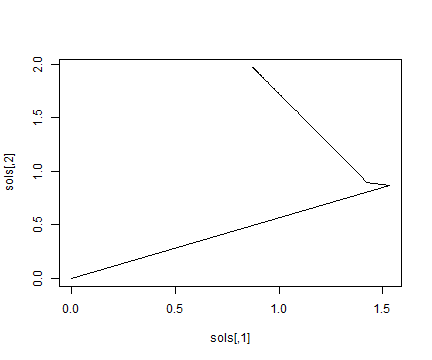

149
[0.872983, 1.96865]


In [129]:
solution, sse, iters, sols = grl_fixed(A,b,x0; alpha=alpha, maxiter=200);
println(iters)
println(solution)
@rput sols
reval("plot(sols, type='l')");

### Strategy 4:  $\min_\alpha \lVert I - \alpha AA'\rVert_2^2 \lVert x^+-x^* \rVert^2_2$

This produces the same $\alpha$ as strategy 3.

## Gradient Descent and Eigenvalues

In [130]:
include("../jl/gen_eigm.jl")
using LinearAlgebra

A = gen_eigm([2, 1]);
x = [1,2]
b = A*x

2-element Array{Float64,1}:
 0.5308000399503148
 4.103847423568188 

In [131]:
display(A)
eigvals(A)

2×2 Array{Float64,2}:
 0.983984  -0.226592
 0.071815   2.01602 

2-element Array{Float64,1}:
 1.0
 2.0

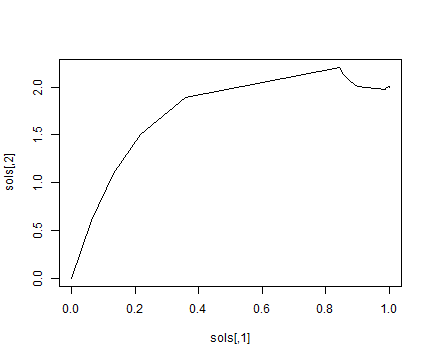

17
[1.00014, 2.00001]


In [132]:
x0 = [0,0]
solution, sse, iters, sols = grl_2(A,b,x0,x; maxiter=500);
println(iters)
println(solution)
@rput sols
reval("plot(sols, type='l')");

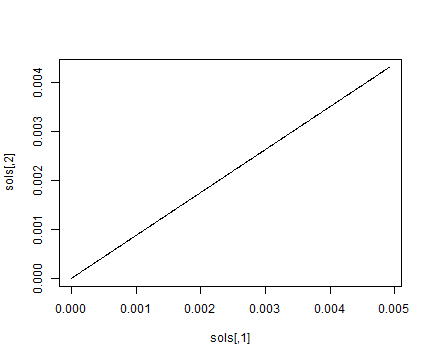

500
[0.0049132, 0.00430825]


In [133]:
A = gen_eigm([4, 1]);
x = [1,2]
b = A*x
x0 = [0,0]
solution, sse, iters, sols = grl_2(A,b,x0,x; maxiter=500);
println(iters)
println(solution)
@rput sols
reval("plot(sols, type='l')");

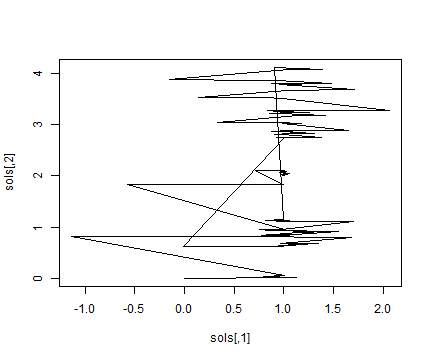

988
[1.00145, 2.00797]


In [134]:
A = gen_eigm([5, 1]);
x = [1,2]
b = A*x
x0 = [0,0]
solution, sse, iters, sols = grl_2(A,b,x0,x; maxiter=1000);
println(iters)
println(solution)
@rput sols
reval("plot(sols, type='l')");